In [6]:
%run "..\features\train-test_split.ipynb"

         date  close  log_close
0  2015-11-24  37.59       3.63
1  2015-11-25  37.59       3.63
2  2015-11-26  37.82       3.63
3  2015-11-27  37.68       3.63
4  2015-11-28  37.68       3.63
            close  log_close
date                        
2015-11-24  37.59       3.63
2015-11-25  37.59       3.63
2015-11-26  37.82       3.63
2015-11-27  37.68       3.63
2015-11-28  37.68       3.63
[array([0.03269828, 0.03269828, 0.03425213, 0.03330631, 0.03330631,
       0.03330631, 0.03391434, 0.04175111, 0.04060262, 0.04006215,
       0.03871099, 0.03871099, 0.03871099, 0.03891366, 0.03519795,
       0.02945548, 0.03107688, 0.03087421, 0.03087421, 0.03087421,
       0.02999595, 0.03256317, 0.03715714, 0.03972436, 0.03702202,
       0.03702202, 0.03702202, 0.04303473, 0.04134576, 0.041616  ,
       0.04188623, 0.04188623, 0.04188623, 0.04188623, 0.04026483,
       0.03992704, 0.0372247 , 0.0388461 , 0.04168356, 0.04168356,
       0.04168356, 0.03756249, 0.04735847, 0.05235779, 0.04675044,
 

In [7]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3046/3046 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - loss: 0.0016


In [9]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_train_pred_inv = scaler.inverse_transform(y_train_pred)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_test_pred_inv - y_test) ** 2)))
rmse

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


np.float64(5.208619092445382)

In [10]:

last_sequence = scaled_data[-60:]
# Reshape to 3D (samples, timesteps, features)
last_sequence = np.reshape(last_sequence, (1, 60, 1))

future_predictions = []
n_future = 10  # how many days to predict

for _ in range(n_future):
    pred_price = model.predict(last_sequence)
    
    # Save prediction
    future_predictions.append(pred_price[0,0])
    
    # Append prediction and remove oldest value
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred_price[0, 0]]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [11]:
# Inverse transform to original price scale
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = scaler.inverse_transform(future_predictions)

# Generate future dates
last_date = stock_lstm_df.index[-1]
future_dates = pd.date_range(last_date, periods=n_future+1, freq='B')[1:]  # 'B' = business days

# Create dataframe
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
forecast_df.set_index('Date', inplace=True)

C:\Users\amjit\AppData\Local\Temp\ipykernel_11412\1147302808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_test_pred_inv


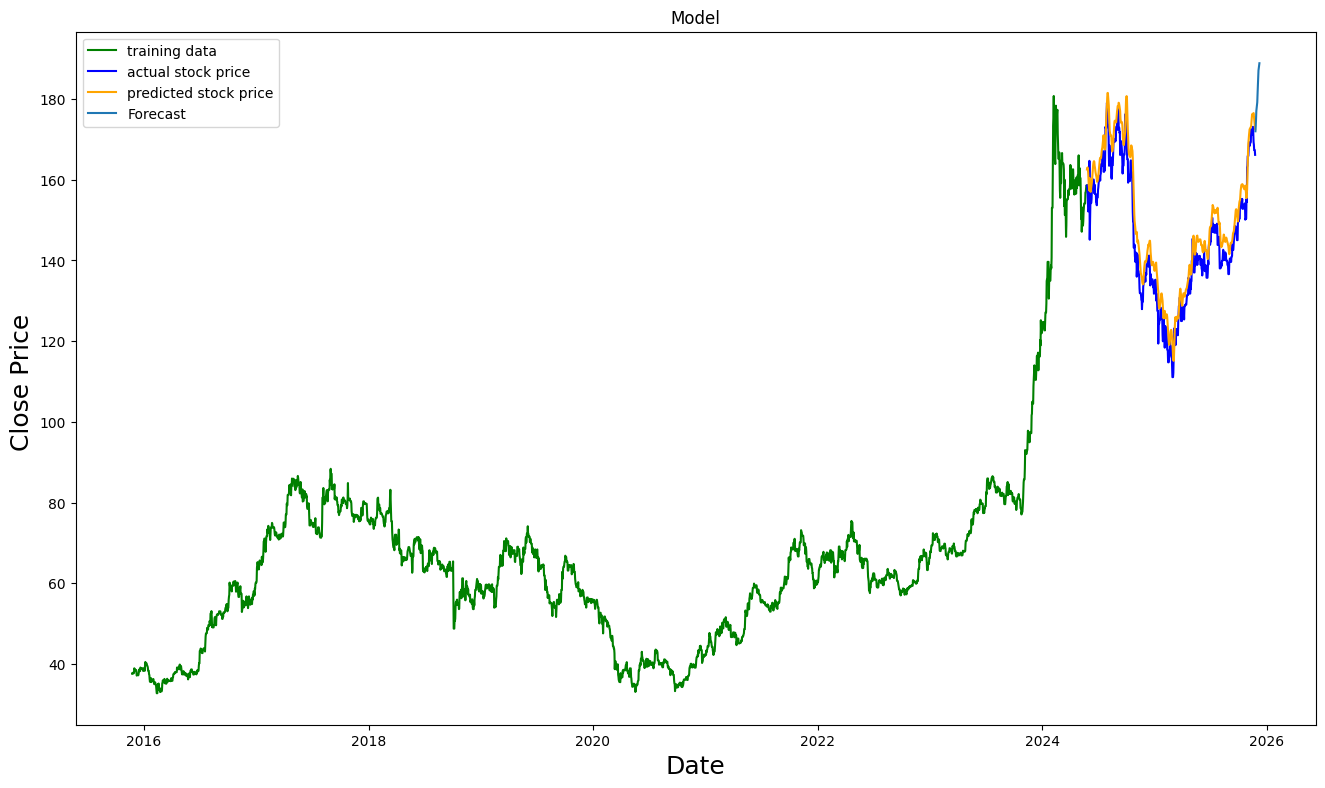

In [12]:
train = stock_lstm_df[:training_data_len]
valid = stock_lstm_df[training_data_len:]
valid['Predictions'] = y_test_pred_inv
# Visualize the data
plt.figure(figsize=(16,9))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.plot(train['close'],color = 'green' , label= 'training data')
plt.plot(valid['close'], color = 'blue', label = 'actual stock price')
plt.plot(valid['Predictions'], color = 'orange', label = 'predicted stock price')
plt.plot(forecast_df, label = 'Forecast')
plt.legend()
plt.show()

In [13]:
forecast_df

,Predicted_Close
Date,
2025-11-25,172.025299
2025-11-26,173.198029
2025-11-27,175.014542
2025-11-28,177.078979
2025-12-01,179.206421
2025-12-02,181.307007
2025-12-03,183.337540
2025-12-04,185.279739
2025-12-05,187.129715
